# Post processing

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymysql
import eeweather
import pytz
from datetime import datetime, timedelta

## Hyperparameter

In [2]:
# mysql
HOST = 'ENDPOINT'
USER = 'USER'
PASSWORD = 'PASSWORD'
PORT = 3306
DB = 'DB'
DATE = (datetime.now() - timedelta(days = 7)).strftime('%Y-%m-%d')
print(DATE)

# denver international airport
LAT = 39.83
LON = -104.65

# data
PATH_CSV_01 = '/home/ubuntu/github/airflow-automation/01_notebooks/post_processing.csv'

plt.style.use('default')

2020-07-17


## Forecast temperature from RDS

In [3]:
# connection
connection = pymysql.connect(host=HOST, user=USER, password=PASSWORD, port=PORT, db=DB)

# query
query = """
SELECT
  *
FROM
  jupyterdb.nam_data
WHERE
  DATE(created_at) >= '{}'
""".format(DATE)

# make dataframe
df = pd.read_sql(query, con = connection)

# index
df['validity_time_str'] = ['0' + str(v // 100) if (v // 100) < 10 else str(v // 100) for v in df['validity_time']]
df['validity_index'] = df['validity_date'].astype(str) + ' ' + df['validity_time_str']
df['validity_index'] = pd.to_datetime(df['validity_index'], format = '%Y%m%d %H')
df = df.set_index('validity_index').tz_localize('UTC').tz_convert('America/Denver').tz_localize(None).sort_index()
df['data_time_str'] = ['0' + str(v // 100) if (v // 100) < 10 else str(v // 100) for v in df['data_time']]
df['data_index'] = df['data_date'].astype(str) + ' ' + df['data_time_str']
df['data_index'] = pd.to_datetime(df['data_index'], format = '%Y%m%d %H')
df['data_index'] = df['data_index'].dt.tz_localize('UTC').dt.tz_convert('America/Denver').dt.tz_localize(None)

# make columns
df['model'] = df['data_date'].astype(str) + '_' + df['data_time_str']
df['horizon'] = ((df.index - df['data_index']).dt.total_seconds() // 3600).astype(int)
df['forecast_temp_f'] = df['value'] * 9/5 - 459.67

In [4]:
df.head(2)

,name,latitude,longitude,level,type_of_level,data_date,data_time,validity_date,validity_time,value,unit,created_at,validity_time_str,data_time_str,data_index,model,horizon,forecast_temp_f
validity_index,,,,,,,,,,,,,,,,,,
2020-07-17 18:00:00,Temperature,39.83,-104.65,0,surface,20200718,0,20200718,0,310.358404,K,2020-07-20 00:24:17,00,00,2020-07-17 18:00:00,20200718_00,0,98.975126
2020-07-17 19:00:00,Temperature,39.83,-104.65,0,surface,20200718,0,20200718,100,306.169533,K,2020-07-20 00:24:17,01,00,2020-07-17 18:00:00,20200718_00,1,91.435159


In [5]:
df.tail(2)

,name,latitude,longitude,level,type_of_level,data_date,data_time,validity_date,validity_time,value,unit,created_at,validity_time_str,data_time_str,data_index,model,horizon,forecast_temp_f
validity_index,,,,,,,,,,,,,,,,,,
2020-07-26 15:00:00,Temperature,39.83,-104.65,0,surface,20200723,1200,20200726,2100,310.252388,K,2020-07-23 20:13:45,21,12,2020-07-23 06:00:00,20200723_12,81,98.784299
2020-07-26 18:00:00,Temperature,39.83,-104.65,0,surface,20200723,1200,20200727,0,302.419748,K,2020-07-23 20:13:45,00,12,2020-07-23 06:00:00,20200723_12,84,84.685546


## Actual temperature

In [6]:
ranked_stations = eeweather.rank_stations(LAT, LON)
station, warnings = eeweather.select_station(ranked_stations)
print('station.name', station.name)
print('warnings', warnings)

start_date = datetime(df.index[0].year, df.index[0].month, df.index[0].day, tzinfo = pytz.UTC)
end_date = datetime(df.index[-1].year, df.index[-1].month, df.index[-1].day, tzinfo = pytz.UTC)
print(start_date, end_date)
tempC = station.load_isd_hourly_temp_data(start_date, end_date)
tempF = (tempC[0] * 1.8 + 32).to_frame(name = 'temp_f')

tempF = tempF.tz_convert('America/Denver')
tempF = tempF.tz_localize(None)
tempF = tempF.loc[~tempF.index.duplicated(keep = 'first')]

tempF = tempF.dropna().sort_index()

df_temp = tempF.copy()

station.name DENVER INTERNATIONAL AIRPORT
warnings []
2020-07-17 00:00:00+00:00 2020-07-23 00:00:00+00:00


In [7]:
df_temp.head(2)

,temp_f
2020-07-16 18:00:00,81.34448
2020-07-16 19:00:00,78.87236


In [8]:
df_temp.tail(2)

,temp_f
2020-07-19 23:00:00,69.44936
2020-07-20 00:00:00,70.18556


## Merge

In [9]:
df_merge = df.copy()[['forecast_temp_f', 'model', 'data_index', 'horizon']]
df_merge['actual_temp_f'] = df_temp['temp_f']
df_merge['error'] = df_merge['actual_temp_f'] - df_merge['forecast_temp_f']
df_merge['percent_error'] = (df_merge['actual_temp_f'] - df_merge['forecast_temp_f']) / df_merge['actual_temp_f']

In [10]:
df_merge.head(2)

,forecast_temp_f,model,data_index,horizon,actual_temp_f,error,percent_error
validity_index,,,,,,,
2020-07-17 18:00:00,98.975126,20200718_00,2020-07-17 18:00:00,0,88.49678,-10.478346,-0.118404
2020-07-17 19:00:00,91.435159,20200718_00,2020-07-17 18:00:00,1,84.36614,-7.069019,-0.083790


In [11]:
df_merge.tail(2)

,forecast_temp_f,model,data_index,horizon,actual_temp_f,error,percent_error
validity_index,,,,,,,
2020-07-23 15:00:00,108.677626,20200720_12,2020-07-20 06:00:00,81,NaN,NaN,NaN
2020-07-23 18:00:00,97.481253,20200720_12,2020-07-20 06:00:00,84,NaN,NaN,NaN


## Time series plot

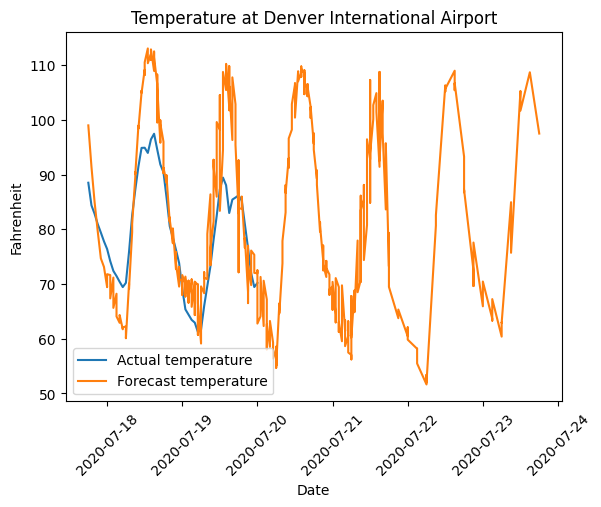

In [12]:
plt.plot(df_merge['actual_temp_f'], label = 'Actual temperature')
plt.plot(df_merge['forecast_temp_f'], label = 'Forecast temperature')
plt.title('Temperature at Denver International Airport')
plt.xlabel('Date')
plt.ylabel('Fahrenheit')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

## Hourly forecast error

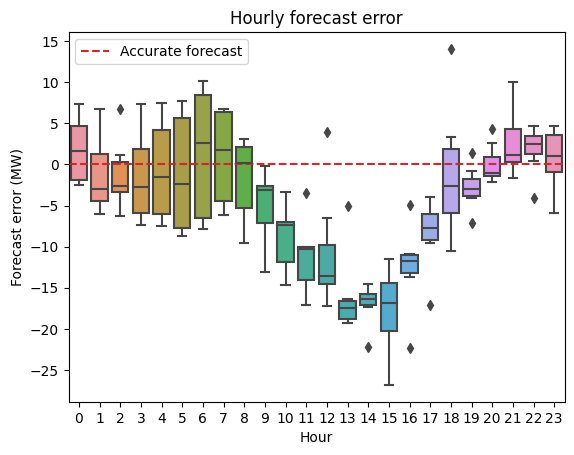

In [13]:
sns.boxplot(x = df_merge.index.hour, y = df_merge['error'])
plt.axhline(y = 0, linestyle = '--', color = '#d62728', label = 'Accurate forecast')
plt.title('Hourly forecast error')
plt.xlabel('Hour')
plt.ylabel('Forecast error (MW)')
plt.legend()
plt.show()

In [17]:
groupby = df_merge.groupby([df_merge.index.hour]).mean()['error'].to_frame('mean_error')
groupby.index = groupby.index.rename('hour')

groupby

,mean_error
hour,
0,1.777222
1,-1.209620
2,-1.157282
3,-1.505633
4,-0.734090
5,-1.172220
6,1.224668
7,0.939233
8,-1.725220


## Save CSV

In [21]:
groupby.to_csv(PATH_CSV_01, index = True)